In [1]:
import lobi as lb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import cv2 as cv
import os
import serial
from tqdm import tqdm
import schunk

## Messung
- [Index](index.ipynb)

Hier werden alle Parameter und Informationen für den Datensatz übergeben.    
- `Messung` Name des Dateiordners. Bsp.: Zylinder P(0.5,0)
- `Elektroden` Anzahl der messenden Elektroden [16,32]. Dementsprechend wir 'd' oder 'e' an das SpectraEIT-Kit gesendet.
- `SchunkStep` Schrittweite zwischen den Messungen
- `Leitwert` gemessen mit Leitwertmessgerät
- `Temperatur` Raumtemperatur
- `Wasserstand` Wasserstand ist die Variable für die höhe der eingefüllten Flüssigkeit
- `Sonstiges` Weitere Informationen können vorab über dieses Feld hinzugefügt werden. Diese Variable wird über die gesamte Messdatenaufnahme nicht mehr aufgerufen.
- `Objekt` Umfasst die in dem Messbereich eingefügten Messobjekte. Muss bei der `ground_truth` Funktion selbst neu eingefügt werden.

In [2]:
#Globale Angaben einer Messreihe
Messung     = 'Zylinder P(0.5,0)' # Dateiordnername
Elektroden  = 16                  # Anzahl der Elektroden
SchunkStep  = 5                   #[grad/Schritt]
Leitwert    = 1                   # Leitfähigkeit Wasser
Temperatur  = 20                  # Raumtemperatur [°C]
Wasserstand = 33                  # Wasserstand [mm]
Sonstiges   = 'Keine weiteren Angaben'
Objekt      = 'Quader'
Anzahl      = 50                  #Anzahl der aufzunehmenden Messwerte

In [3]:
#SchrittArray für Schunk Drehteller:
GRAD = np.arange(0,361,SchunkStep)
GRAD

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190,
       195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255,
       260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320,
       325, 330, 335, 340, 345, 350, 355, 360])

In [4]:
lb.gen_env(Messung,Elektroden,SchunkStep,Leitwert,Temperatur, Wasserstand, Sonstiges)

Ordner mit dem Namen:" Zylinder P(0.5,0) " wurde erstellt.


FileExistsError: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'Zylinder P(0.5,0)'

## Herstellen Verbindung Schunk

In [2]:
mod = schunk.Module(schunk.SerialConnection(0x0B, serial.Serial, port='COM3', baudrate=9600, timeout=1))

## (try:) Herstellen der Verbindung zum Spectra EIT-Kit und Übergabe des Messmodus

In [ ]:
serialPort = lb.init_with_nel("COM4",Elektroden)

## Herstellen der Verbindung zum Spectra EIT-Kit

In [6]:
#serialPort = lb.init("COM7")
serialPort = lb.init("COM4")

Verbindung zu: COM4 erfolgreich hergestellt.


## Testen Schunk

In [23]:
angles=np.arange(0,361,90) #(0,361,90)
angles
for angle in angles:
    mod.move_pos(angle)
    mod.wait_until_position_reached()
    print(angle)
mod.move_pos(0)

0
90
180
270
360


24.256122589111328

In [3]:
mod.move_pos(0)

2.922583818435669

## Ground truth
Es müssen Arrays übergeben werden. Grundsätzlich müssen die Anzahl der in den Arrays enthaltenen Elementen identisch sein.
- `['rectangle','circle','triangle']` Auswahl eines oder mehrerer gleicher oder unterschiedlicher Elemente
- `[r]` Abstand des Gegenstandes vom Mittelpunkt in Prozent ($r[\%] = \sqrt{x^2+y^2}\cdot 100$)
- `[α]` Winkel bezogen auf die $x$-Achse des Gegenstandes. Drehrichtung ist abhängig von `clockdirection`
- `Dir` Verzeichnes in dem das Groundtruth Bild gespeichert werden soll.

optional:
- `clockdirection` Drehung um den Winkel α _in_ oder _gegen_ der Uhrzeigersinn
- `save_img` default `save_img = True`

Bild gespeichert


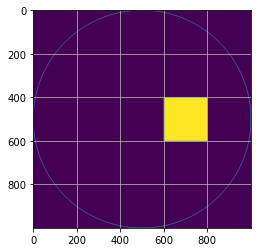

In [5]:
#Kartesische Eingabe
P_x_y = [0.5,0]
R = lb.CarCirc(P_x_y)
#Manuelle prozentuale Eingabe:
#R = [100]
img1 = lb.ground_truth(['rectangle'],R,[0*np.pi], Messung ,save_img=True)
plt.grid()
plt.imshow(img1,cmap='viridis')

In [15]:
4//2

2

In [19]:
range?

Init signature: range(self, /, *args, **kwargs)
Docstring:     
range(stop) -> range object
range(start, stop[, step]) -> range object

Return an object that produces a sequence of integers from start (inclusive)
to stop (exclusive) by step.  range(i, j) produces i, i+1, i+2, ..., j-1.
start defaults to 0, and stop is omitted!  range(4) produces 0, 1, 2, 3.
These are exactly the valid indices for a list of 4 elements.
When step is given, it specifies the increment (or decrement).
Type:           type
Subclasses:     


In [20]:
for i in range(0,4,2):
    print(i)

0
2


## Mittelwert ohne Probe aufnehmen
- Beachten, dass keine Probe in der Messumgebung ist

In [9]:
Mean = []
Anzahl_mean = 20
try:
    print('Messung des Mittelwertbildes')    
    Mean = lb.measure_data(Anzahl_mean,serialPort)
except:
    Mean = []
    print('Bitte erneut ausführen')
Mean = np.mean(Mean,0)

Messung des Mittelwertbildes
Vorgang:  1 von:  20
Vorgang:  2 von:  20
Vorgang:  2 von:  20
Vorgang:  3 von:  20
Vorgang:  4 von:  20
Vorgang:  5 von:  20
Vorgang:  6 von:  20
Vorgang:  7 von:  20
Vorgang:  8 von:  20
Vorgang:  9 von:  20
Vorgang:  10 von:  20
Vorgang:  11 von:  20
Vorgang:  12 von:  20
Vorgang:  13 von:  20
Vorgang:  14 von:  20
Vorgang:  15 von:  20
Vorgang:  16 von:  20
Vorgang:  17 von:  20
Vorgang:  18 von:  20
Vorgang:  19 von:  20
Vorgang:  20 von:  20


In [10]:
# Mittelwert speichern?
np.save(str(Messung)+'/'+'Mean_empty_ground', Mean)

In [8]:
Mean = np.load('Zylinder_mittig/Mean_empty_ground.npy')

### Messung für `Anzahl` an Werten starten
- `GRAD` ... Winkelschritte in °.
- `grad` ... wird auf den aktuellen Drehwinkel des Drehtellers gesetzt.
- Wenn die `Data` leer ist, wird die Iteration von `grad` neu gestartet.
- `try` wird zur verhinderung von nicht vollständigen Messungen verwendet.

In [9]:
#temp
GRAD = GRAD[1:]
GRAD

array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130,
       135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195,
       200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260,
       265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325,
       330, 335, 340, 345, 350, 355, 360])

In [ ]:
print('Fortschritt der Winkelschritte:')
pbar = tqdm(total = len(GRAD))
check = 0
Data = []
while check < len(GRAD):
    grad = GRAD[check]
    #--- Schunk Teller auf Position drehen ---
    mod.move_pos(grad)
    mod.wait_until_position_reached()
    #---
    try:
        print('Messung des '+ str(grad) + '° Schritt')    
        Data = lb.measure_data(Anzahl,serialPort)
        lb.export_xlsx(Data,Messung,Mean,grad)
        check +=1
    except:
        Data = []
        print('Neustart. Daten sind nicht vollständig...')
pbar.close()

  0%|                                                                                           | 0/72 [00:00<?, ?it/s]

Fortschritt der Winkelschritte:
Messung des 5° Schritt
Vorgang:  1 von:  50
Neustart. Daten sind nicht vollständig...
Messung des 5° Schritt
Vorgang:  1 von:  50
Vorgang:  1 von:  50
Vorgang:  2 von:  50
Vorgang:  3 von:  50
Vorgang:  4 von:  50
Vorgang:  5 von:  50
Vorgang:  6 von:  50
Vorgang:  7 von:  50
Vorgang:  8 von:  50
Vorgang:  9 von:  50
Vorgang:  10 von:  50
Vorgang:  11 von:  50
Vorgang:  12 von:  50
Vorgang:  13 von:  50
Vorgang:  14 von:  50
Vorgang:  15 von:  50
Vorgang:  16 von:  50
Vorgang:  17 von:  50
Vorgang:  18 von:  50
Vorgang:  19 von:  50
Vorgang:  20 von:  50
Vorgang:  21 von:  50
Vorgang:  22 von:  50
Vorgang:  23 von:  50
Vorgang:  24 von:  50
Vorgang:  25 von:  50
Vorgang:  26 von:  50
Vorgang:  27 von:  50
Vorgang:  28 von:  50
Vorgang:  29 von:  50
Vorgang:  30 von:  50
Vorgang:  31 von:  50
Vorgang:  32 von:  50
Vorgang:  33 von:  50
Vorgang:  34 von:  50
Vorgang:  35 von:  50
Vorgang:  36 von:  50
Vorgang:  37 von:  50
Vorgang:  38 von:  50
Vorgang:  3

## Visualisierung

Die Visualisierung ist über die PyEIT Bibliothek möglich.